# Real estate price model workflow

Sam Maurer, Feb 2018; Paul Waddell, June 2018

Python 3.6, intended to be backward compatible with 2.7

In [11]:
from __future__ import print_function
import warnings;warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from urbansim.utils import misc

In [2]:
from scipy.stats import norm
%matplotlib inline

import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import seaborn as sns
sns.set()

In [3]:
# Standard to run UrbanSim from the root level of the project directory

import os; os.chdir('../..')

In [4]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import OLSRegressionStep
import orca

In [5]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [6]:
import datashader as ds
import holoviews as hv
import geoviews as gv

In [7]:
ds.__version__

'0.6.6'

## Explore the Orca registrations

In [ ]:
orca.list_tables()

In [ ]:
for table_name in orca.list_tables():
    print(table_name.upper())
    print(orca.get_table(table_name).to_frame().columns.tolist())
    print()

In [ ]:
orca.list_broadcasts()

In [ ]:
orca.list_steps()

## Explore the data

Orca doesn't execute code to load the registered objects until it needs to.

In [16]:
parcels = orca.get_table('parcels').to_frame()
parcels.describe()

,development_type_id,land_value,acres,county_id,zone_id,proportion_undevelopable,tax_exempt_status,geom_id,x,y,shape_area,block_id,node_id,node_id_small,node_id_walk
count,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06,1.956207e+06
mean,2.607759e+00,2.348019e+05,2.294288e+00,5.393547e+01,8.293200e+02,1.633774e-03,1.256104e-02,8.795114e+12,-1.221763e+02,3.777351e+01,9.284664e+03,6.054294e+13,3.821563e+08,7.947319e+08,9.292176e+08
std,5.310605e+00,1.610710e+06,3.612166e+01,3.808734e+01,4.129778e+02,4.038695e-02,1.113700e-01,5.076215e+12,2.991972e-01,3.621875e-01,1.461793e+05,3.807600e+11,9.490913e+08,1.402735e+09,1.644742e+09
min,-1.000000e+00,0.000000e+00,4.527090e-07,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.706688e+07,-1.235266e+02,3.689751e+01,1.832050e-03,6.001400e+13,3.028780e+05,2.812660e+05,2.545794e+07
25%,1.000000e+00,3.995700e+04,1.084042e-01,1.300000e+01,4.920000e+02,0.000000e+00,0.000000e+00,4.405538e+12,-1.224059e+02,3.748103e+01,4.386967e+02,6.013321e+13,5.615974e+07,5.787896e+07,5.790266e+07
50%,1.000000e+00,1.008000e+05,1.489650e-01,7.500000e+01,8.440000e+02,0.000000e+00,0.000000e+00,8.793873e+12,-1.221419e+02,3.775390e+01,6.028407e+02,6.075033e+13,6.535137e+07,6.550126e+07,6.552943e+07
75%,1.000000e+00,2.254345e+05,2.294452e-01,8.500000e+01,1.189000e+03,0.000000e+00,0.000000e+00,1.318756e+13,-1.219512e+02,3.798583e+01,9.285328e+02,6.085508e+13,6.562580e+07,6.256488e+08,4.161833e+08
max,2.500000e+01,1.393464e+09,2.335199e+04,9.700000e+01,1.454000e+03,1.000000e+00,1.000000e+00,1.759217e+13,-1.212109e+02,3.886017e+01,9.450224e+07,6.113012e+13,5.458527e+09,5.458527e+09,5.471137e+09


In [14]:
buildings = orca.get_table('buildings').to_frame()
buildings.describe()

,parcel_id,development_type_id,improvement_value,residential_units,residential_sqft,sqft_per_unit,non_residential_sqft,building_sqft,nonres_rent_per_sqft,res_price_per_sqft,stories,year_built,redfin_sale_price,redfin_sale_year,building_type_id,res_sqft_per_unit,node_id_small,node_id_walk
count,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.081100e+06,1.081100e+06,1.824229e+06,1.715474e+06,1.824229e+06,1.824229e+06
mean,1.012861e+06,1.835162e+00,3.186878e+05,1.534000e+00,2.657113e+03,1.669294e+03,1.280864e+03,3.784462e+03,9.218572e-01,2.927191e+02,1.214429e+00,1.965524e+03,5.287307e+05,2.002828e+03,1.710299e+00,1.781741e+03,7.901671e+08,8.926345e+08
std,5.938065e+05,3.441080e+00,3.571671e+06,6.137263e+00,3.012408e+04,1.063476e+03,2.392226e+04,3.494568e+04,4.053916e+00,2.647712e+02,5.567798e-01,2.501754e+01,7.188123e+05,7.143867e+00,2.396463e+00,6.803636e+03,1.400113e+09,1.622640e+09
min,2.600000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.790000e+03,0.000000e+00,1.962000e+03,0.000000e+00,1.015556e+02,2.812660e+05,2.545794e+07
25%,4.958500e+05,1.000000e+00,8.267503e+04,1.000000e+00,1.230000e+03,1.176000e+03,0.000000e+00,1.320000e+03,0.000000e+00,1.518671e+02,1.000000e+00,1.952000e+03,2.390000e+05,1.998000e+03,1.000000e+00,1.200000e+03,5.788284e+07,5.789370e+07
50%,1.002691e+06,1.000000e+00,1.675535e+05,1.000000e+00,1.754000e+03,1.564000e+03,0.000000e+00,1.858000e+03,0.000000e+00,2.544594e+02,1.000000e+00,1.966000e+03,4.000000e+05,2.004000e+03,1.000000e+00,1.626000e+03,6.550126e+07,6.551237e+07
75%,1.532117e+06,1.000000e+00,2.853423e+05,1.000000e+00,2.400000e+03,2.029424e+03,0.000000e+00,2.524000e+03,0.000000e+00,3.699121e+02,1.000000e+00,1.983000e+03,6.500000e+05,2.009000e+03,1.000000e+00,2.042000e+03,6.120713e+08,4.161833e+08
max,2.054501e+06,2.400000e+01,3.355514e+09,1.912000e+03,1.458000e+07,3.000000e+04,1.657310e+07,1.458000e+07,1.289625e+02,5.016109e+04,5.900000e+01,2.015000e+03,1.800000e+08,2.014000e+03,1.600000e+01,7.283880e+06,5.458527e+09,5.471137e+09


In [72]:
buildings.columns

Index(['parcel_id', 'development_type_id', 'improvement_value',
       'residential_units', 'residential_sqft', 'sqft_per_unit',
       'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft',
       'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price',
       'redfin_sale_year', 'redfin_home_type', 'costar_property_type',
       'costar_rent', 'building_type_id', 'res_sqft_per_unit', 'node_id_small',
       'node_id_walk', 'predicted_ln_price_sqft', 'predicted_price_sqft',
       'residuals_price_sqft', 'predicted_price_sqft_sf',
       'residuals_price_sqft_sf', 'predicted_ln_price_sqft_mf',
       'predicted_price_sqft_mf', 'residuals_price_sqft_mf'],
      dtype='object')

In [31]:
buildings['x'] = misc.reindex(parcels.x, buildings.parcel_id) 
buildings['y'] = misc.reindex(parcels.y, buildings.parcel_id) 
orca.add_table('buildings', buildings)

In [18]:
buildings.head()

,parcel_id,development_type_id,improvement_value,residential_units,residential_sqft,sqft_per_unit,non_residential_sqft,building_sqft,nonres_rent_per_sqft,res_price_per_sqft,...,redfin_sale_year,redfin_home_type,costar_property_type,costar_rent,building_type_id,res_sqft_per_unit,node_id_small,node_id_walk,x,y
building_id,,,,,,,,,,,,,,,,,,,,,
1.0,742974.0,1.0,0.00,1.0,2029.0,2029.42425,0.0,2029.42425,0.0,302.769751,...,NaN,NaN,NaN,NaN,1.0,2029.0,110407631,415799033,-122.598671,-122.598671
2.0,744961.0,1.0,0.00,1.0,2029.0,2029.42425,0.0,2029.42425,0.0,254.429279,...,NaN,NaN,NaN,NaN,1.0,2029.0,407087343,415799033,-122.605688,-122.605688
3.0,1442641.0,1.0,53262.87,1.0,1568.0,1568.00000,0.0,1568.00000,0.0,183.474166,...,NaN,NaN,NaN,NaN,1.0,1568.0,65545753,65508066,-122.001466,-122.001466
7.0,328712.0,1.0,0.00,1.0,1393.0,1393.00000,0.0,0.00000,0.0,0.000000,...,2008.0,Single Family Residential,NaN,NaN,1.0,1393.0,1695636890,2542056172,-121.917223,-121.917223
9.0,742661.0,1.0,116580.00,1.0,1018.0,1018.00000,0.0,1018.00000,0.0,474.350534,...,2007.0,Single Family Residential,NaN,NaN,1.0,1018.0,110407631,415799033,-122.594278,-122.594278


## Generate accessibility measures for the price model

The network accessibility metrics are not stored on disk; for now we'll generate them using legacy code.

In [8]:
orca.run(['initialize_network_small'])

INFO:orca.orca:start: run step 'initialize_network_small'


Running step 'initialize_network_small'


INFO:orca.orca:finish: run step 'initialize_network_small'


Time to execute step 'initialize_network_small': 30.41 s
Total time to execute iteration 1 with iteration value None: 30.41 s


In [9]:
orca.run(['initialize_network_walk'])

INFO:orca.orca:start: run step 'initialize_network_walk'


Running step 'initialize_network_walk'


INFO:orca.orca:finish: run step 'initialize_network_walk'


Time to execute step 'initialize_network_walk': 107.47 s
Total time to execute iteration 1 with iteration value None: 107.47 s


In [10]:
orca.broadcast('nodessmall', 'rentals', cast_index=True, onto_on='node_id_small')
orca.broadcast('nodeswalk', 'rentals', cast_index=True, onto_on='node_id_walk')

In [76]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('nodessmall', 'parcels'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'units'),
 ('nodeswalk', 'parcels'),
 ('nodeswalk', 'rentals'),
 ('nodeswalk', 'units')]

In [47]:
orca.run(['network_aggregations_small'])

INFO:orca.orca:start: run step 'network_aggregations_small'
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_small


Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000


INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_small, building_type_id


Computing units_sf_10000


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 1']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_small, building_type_id


Computing units_mf_10000


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 3']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small


Computing pop_10000


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small


Computing hh_10000


INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small, income


Computing poor_10000


INFO:urbansim.utils.networks:    Filters = ['income < 40000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 53660 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small, tenure


Computing renters_10000


INFO:urbansim.utils.networks:    Filters = ['tenure == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 103635 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = income, node_id_small


Computing avg_income_10000


INFO:urbansim.utils.networks:    dataframe = households, varname=income
INFO:urbansim.utils.networks:    radius = 10000, aggregation = ave, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small


Computing jobs_10000


INFO:urbansim.utils.networks:    dataframe = jobs, varname=None
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = rent, node_id_small
INFO:urbansim.utils.networks:    dataframe = rentals, varname=rent
INFO:urbansim.utils.networks:    radius = 10000, aggregation = ave, decay = flat


Computing avg_rent_10000


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, race_of_head


Computing pop_white_10000


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, race_of_head


Computing pop_black_10000


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, race_of_head


Computing pop_asian_10000


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, hispanic_head


Computing pop_hisp_10000


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 10000, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_small


Computing units_25000


INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_small, building_type_id


Computing units_sf_25000


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 1']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_small, building_type_id


Computing units_mf_25000


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 3']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small


Computing pop_25000


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small


Computing hh_25000


INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small, income


Computing poor_25000


INFO:urbansim.utils.networks:    Filters = ['income < 40000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 53660 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small, tenure


Computing renters_25000


INFO:urbansim.utils.networks:    Filters = ['tenure == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 103635 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = income, node_id_small


Computing avg_income_25000


INFO:urbansim.utils.networks:    dataframe = households, varname=income
INFO:urbansim.utils.networks:    radius = 25000, aggregation = ave, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_small


Computing jobs_25000


INFO:urbansim.utils.networks:    dataframe = jobs, varname=None
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = rent, node_id_small
INFO:urbansim.utils.networks:    dataframe = rentals, varname=rent
INFO:urbansim.utils.networks:    radius = 25000, aggregation = ave, decay = flat


Computing avg_rent_25000


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, race_of_head


Computing pop_white_25000


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, race_of_head


Computing pop_black_25000


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, race_of_head


Computing pop_asian_25000


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_small, hispanic_head


Computing pop_hisp_25000


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 25000, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:orca.orca:finish: run step 'network_aggregations_small'


         units_10000  units_sf_10000  units_mf_10000      pop_10000  \
count   30826.000000    30826.000000    30826.000000   30826.000000   
mean   111656.078125    60759.140625    45984.058594  259194.703125   
std     87205.929688    37438.925781    46023.648438  187603.703125   
min         0.000000        0.000000        0.000000       0.000000   
25%     43964.500000    31221.500000    10558.000000  107475.750000   
50%     96821.500000    59398.000000    32530.500000  233979.000000   
75%    163121.750000    90068.500000    69672.000000  387446.000000   
max    406854.000000   147995.000000   205873.000000  848002.000000   

            hh_10000    poor_10000  renters_10000  avg_income_10000  \
count   30826.000000  30826.000000   30826.000000      30826.000000   
mean    98975.984375  24028.119141   46257.820312     112503.523438   
std     77820.148438  21383.816406   46188.039062      27946.423828   
min         0.000000      0.000000       0.000000          0.000000   
25%  

In [20]:
orca.run(['network_aggregations_walk'])

INFO:orca.orca:start: run step 'network_aggregations_walk'
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk


Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = sqft_per_unit, node_id_walk


Computing sqft_unit_500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=sqft_per_unit
INFO:urbansim.utils.networks:    radius = 500, aggregation = ave, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, persons


Computing singles_500_walk


INFO:urbansim.utils.networks:    Filters = ['persons == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 52731 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, age_of_head


Computing elderly_hh_500_walk


INFO:urbansim.utils.networks:    Filters = ['age_of_head > 65']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 34788 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = children, node_id_walk


Computing children_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=children
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_sf_500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 1']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_mf_500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 3']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk


Computing pop_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing hh_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing poor_500_walk


INFO:urbansim.utils.networks:    Filters = ['income < 40000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 53660 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing rich_500_walk


INFO:urbansim.utils.networks:    Filters = ['income > 150000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 39177 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, tenure


Computing renters_500_walk


INFO:urbansim.utils.networks:    Filters = ['tenure == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 103635 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = income, node_id_walk


Computing avg_income_500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=income
INFO:urbansim.utils.networks:    radius = 500, aggregation = ave, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing jobs_500_walk


INFO:urbansim.utils.networks:    dataframe = jobs, varname=None
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = rent, node_id_walk
INFO:urbansim.utils.networks:    dataframe = rentals, varname=rent
INFO:urbansim.utils.networks:    radius = 500, aggregation = ave, decay = flat


Computing avg_rent_500_walk


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_white_500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_black_500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_asian_500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, hispanic_head


Computing pop_hisp_500_walk


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 500, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk


Computing units_1500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = sqft_per_unit, node_id_walk


Computing sqft_unit_1500_walk


INFO:urbansim.utils.networks:    dataframe = buildings, varname=sqft_per_unit
INFO:urbansim.utils.networks:    radius = 1500, aggregation = ave, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, persons


Computing singles_1500_walk


INFO:urbansim.utils.networks:    Filters = ['persons == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 52731 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, age_of_head


Computing elderly_hh_1500_walk


INFO:urbansim.utils.networks:    Filters = ['age_of_head > 65']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 34788 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = children, node_id_walk


Computing children_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=children
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_sf_1500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 1']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = residential_units, node_id_walk, building_type_id


Computing units_mf_1500_walk


INFO:urbansim.utils.networks:    Filters = ['building_type_id == 3']
INFO:urbansim.utils.networks:    dataframe = buildings, varname=residential_units
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk


Computing pop_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing hh_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing poor_1500_walk


INFO:urbansim.utils.networks:    Filters = ['income < 40000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 53660 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, income


Computing rich_1500_walk


INFO:urbansim.utils.networks:    Filters = ['income > 150000']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 39177 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk, tenure


Computing renters_1500_walk


INFO:urbansim.utils.networks:    Filters = ['tenure == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 103635 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = income, node_id_walk


Computing avg_income_1500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=income
INFO:urbansim.utils.networks:    radius = 1500, aggregation = median, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = node_id_walk


Computing jobs_1500_walk


INFO:urbansim.utils.networks:    dataframe = jobs, varname=None
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat
INFO:urbansim.utils.networks:    Fields available to aggregate = rent, node_id_walk
INFO:urbansim.utils.networks:    dataframe = rentals, varname=rent
INFO:urbansim.utils.networks:    radius = 1500, aggregation = median, decay = flat


Computing avg_rent_1500_walk


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_white_1500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_black_1500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_asian_1500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, hispanic_head


Computing pop_hisp_1500_walk


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 1500, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk


Computing pop_2500_walk


INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 191599 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_white_2500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 1']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 108381 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_black_2500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 2']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 10605 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, race_of_head


Computing pop_asian_2500_walk


INFO:urbansim.utils.networks:    Filters = ['race_of_head == 6']
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 51665 rows because they contain missing values


INFO:urbansim.utils.networks:    Fields available to aggregate = persons, node_id_walk, hispanic_head


Computing pop_hisp_2500_walk


INFO:urbansim.utils.networks:    Filters = ["hispanic_head == 'yes'"]
INFO:urbansim.utils.networks:    dataframe = households, varname=persons
INFO:urbansim.utils.networks:    radius = 2500, aggregation = sum, decay = flat


Removed 31878 rows because they contain missing values


INFO:orca.orca:finish: run step 'network_aggregations_walk'


       units_500_walk  sqft_unit_500_walk  singles_500_walk  \
count   415716.000000       415716.000000     415716.000000   
mean       356.008972         1245.544556         89.887329   
std       1097.037720          979.879944        323.945648   
min          0.000000            0.000000          0.000000   
25%          9.000000          458.249519          1.000000   
50%        188.000000         1315.694275         28.000000   
75%        440.000000         1761.837921         86.000000   
max     184995.000000        30000.000000      45986.000000   

       elderly_hh_500_walk  children_500_walk  units_sf_500_walk  \
count        415716.000000      415716.000000      415716.000000   
mean             60.195038         161.779861         163.916275   
std             240.503342         448.370270         704.597778   
min               0.000000           0.000000           0.000000   
25%               1.000000           4.000000           2.000000   
50%              29.0000

In [21]:
nodeswalk = orca.get_table('nodeswalk').to_frame()

In [22]:
nodeswalk.to_csv('data/nodeswalk_vars.csv')

In [ ]:
orca.list_tables()

In [ ]:
print(orca.get_table('nodesdrive').to_frame().columns.tolist())

In [ ]:
nodesdrive = orca.get_table('nodesdrive').to_frame()

In [ ]:
nodessmall = orca.get_table('nodessmall').to_frame()

In [ ]:
from scipy.stats import norm
%matplotlib inline

import matplotlib.pyplot as plt, matplotlib.cm as cm, matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import seaborn as sns
sns.set()

In [ ]:
plt.rcParams['figure.figsize']=8,8
%matplotlib inline

sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(nodessmall.med_income_10000, bins=500,  fit=norm, kde=False)

In [ ]:
print('{} nodes have median income zero or below'.format(len(nodessmall[nodessmall.med_income_10000 == -1])))

print('Total nodes count {}'.format(len (nodessmall)))

# Estimate a price model

The basic idea of the parcel template is that we create model steps by _passing arguments to classes_ rather than by writing Python functions and giving them Orca decorators, as we would for a fully custom model.

Much of the functionality for this is already built into UrbanSim and Orca, we'll just need to extend things here and there.

This demo uses a new RegressionStep() class that provides a full model development workflow: estimating a model, registering it with Orca, saving it for future use.

### Specify parameters and pass them to a model object

In [104]:
buildings_sf = buildings[(buildings['redfin_sale_year'] > 2010) & (buildings['residential_units'] == 1) & \
            (buildings['sqft_per_unit'] > 50) & (buildings['res_price_per_sqft'] < 2000)]
orca.add_table('buildings_sf', buildings_sf)


In [105]:
orca.list_tables()

['parcels',
 'buildings',
 'craigslist',
 'rentals',
 'nodessmall',
 'nodeswalk',
 'units',
 'households',
 'persons',
 'jobs',
 'buildings_sf']

In [102]:
m = OLSRegressionStep()
m.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m.filters = 'redfin_sale_year > 2010 & residential_units == 1 & sqft_per_unit > 50 & res_price_per_sqft < 2000'
m.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + year_built > 2010 + \
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) + \
    np.log(avg_income_500_walk+1) + np.log(avg_income_10000+1) + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_25000 + 1) + np.log(pop_25000 + 1) +\
    np.log(pop_500_walk+1) + np.log(pop_black_500_walk+1) + np.log(pop_hisp_500_walk+1) + \
    np.log(pop_asian_500_walk+1)  '
m.name = 'hedonic_price_sqft_single_family'
m.tags = ['paul', 'version 1']
m.fit()

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.380
Model:                                      OLS   Adj. R-squared:                  0.380
Method:                           Least Squares   F-statistic:                     5446.
Date:                          Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                                  11:27:27   Log-Likelihood:            -1.6634e+05
No. Observations:                        160122   AIC:                         3.327e+05
Df Residuals:                            160103   BIC:                         3.329e+05
Df Model:                                    18                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [103]:
buildings.describe()

,parcel_id,development_type_id,improvement_value,residential_units,residential_sqft,sqft_per_unit,non_residential_sqft,building_sqft,nonres_rent_per_sqft,res_price_per_sqft,...,x,y,predicted_ln_price_sqft,predicted_price_sqft_sf,residuals_price_sqft_sf,X,Y,predicted_ln_price_sqft_mf,predicted_price_sqft_mf,residuals_price_sqft_mf
count,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,...,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06,1.824229e+06
mean,1.012861e+06,1.835162e+00,3.186878e+05,1.534000e+00,2.657113e+03,1.669294e+03,1.280864e+03,3.784462e+03,9.218572e-01,2.927191e+02,...,-1.221742e+02,3.776760e+01,5.580638e+00,4.076356e+02,1.149164e+02,-1.360037e+07,4.546770e+06,5.646980e+00,1.071224e+03,7.785048e+02
std,5.938065e+05,3.441080e+00,3.571671e+06,6.137263e+00,3.012408e+04,1.063476e+03,2.392226e+04,3.494568e+04,4.053916e+00,2.647712e+02,...,2.928235e-01,3.579133e-01,8.278038e-01,7.231816e+02,8.022574e+02,3.259696e+04,5.044440e+04,1.041063e+00,6.427331e+03,6.467341e+03
min,2.600000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.235259e+02,3.690070e+01,-1.135076e+01,-9.999882e-01,-5.000668e+04,-1.375084e+07,4.425275e+06,-1.174671e+00,-6.910794e-01,-5.006573e+04
25%,4.958500e+05,1.000000e+00,8.267503e+04,1.000000e+00,1.230000e+03,1.176000e+03,0.000000e+00,1.320000e+03,0.000000e+00,1.518671e+02,...,-1.224045e+02,3.747697e+01,5.194814e+00,1.793346e+02,-8.685049e+01,-1.362601e+07,4.505800e+06,5.166274e+00,1.742606e+02,-1.075883e+02
50%,1.002691e+06,1.000000e+00,1.675535e+05,1.000000e+00,1.754000e+03,1.564000e+03,0.000000e+00,1.858000e+03,0.000000e+00,2.544594e+02,...,-1.221402e+02,3.775026e+01,5.534003e+00,2.521554e+02,-1.003968e+01,-1.359658e+07,4.544206e+06,5.465301e+00,2.353469e+02,-2.381495e+01
75%,1.532117e+06,1.000000e+00,2.853423e+05,1.000000e+00,2.400000e+03,2.029424e+03,0.000000e+00,2.524000e+03,0.000000e+00,3.699121e+02,...,-1.219521e+02,3.798150e+01,5.871940e+00,3.539368e+02,5.711731e+01,-1.357564e+07,4.576813e+06,5.796413e+00,3.281169e+02,5.428844e+01
max,2.054501e+06,2.400000e+01,3.355514e+09,1.912000e+03,1.458000e+07,3.000000e+04,1.657310e+07,1.458000e+07,1.289625e+02,5.016109e+04,...,-1.212137e+02,3.885770e+01,1.022154e+01,2.748789e+04,2.748789e+04,-1.349345e+07,4.701309e+06,1.430688e+01,1.634555e+06,1.634555e+06


In [98]:
buildings = orca.get_table('buildings').to_frame()
buildings_sf = buildings[(buildings['redfin_sale_year'] > 2010) & (buildings['residential_units'] == 1) & \
            (buildings['sqft_per_unit'] > 50) & (buildings['res_price_per_sqft'] < 2000)]

buildings['predicted_ln_price_sqft'] = 0.0
orca.add_table('buildings_sf', buildings_sf)
m.out_column = 'predicted_ln_price_sqft'
m.run()

In [59]:
buildings['predicted_price_sqft_sf'] = np.exp(buildings['predicted_ln_price_sqft']) - 1

In [60]:
buildings['residuals_price_sqft_sf'] = buildings.predicted_price_sqft_sf - buildings.res_price_per_sqft

In [76]:
buildings[['res_price_per_sqft','predicted_price_sqft_sf','residuals_price_sqft_sf']][buildings.residential_units == 1].describe()

,res_price_per_sqft,predicted_price_sqft_sf,residuals_price_sqft_sf
count,1.418200e+06,1.418200e+06,1.418200e+06
mean,2.984734e+02,2.659748e+02,-3.249858e+01
std,2.037363e+02,1.402543e+02,1.824803e+02
min,0.000000e+00,-9.919934e-01,-5.000668e+04
25%,1.720888e+02,1.750353e+02,-8.584448e+01
50%,2.633638e+02,2.423339e+02,-1.601787e+01
75%,3.712024e+02,3.309792e+02,3.900653e+01
max,5.016109e+04,8.281267e+03,8.281267e+03


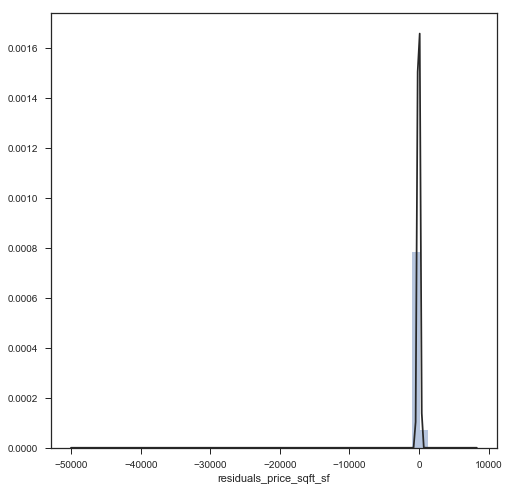

In [62]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(buildings[buildings.residential_units == 1].residuals_price_sqft_sf, fit=norm, kde=False)

In [63]:
from pyproj import Proj, transform

# WGS 84
inProj = Proj(init='epsg:4326')

# Web mercator 
outProj = Proj(init='epsg:3857')

buildings['X'],buildings['Y'] = transform(inProj,outProj,buildings['x'].values,buildings['y'].values)
buildings[['X','Y']].head()

,X,Y
building_id,,
1.0,-1.364762e+07,4.578012e+06
2.0,-1.364840e+07,4.575862e+06
3.0,-1.358114e+07,4.487268e+06
7.0,-1.357176e+07,4.503734e+06
9.0,-1.364713e+07,4.577583e+06


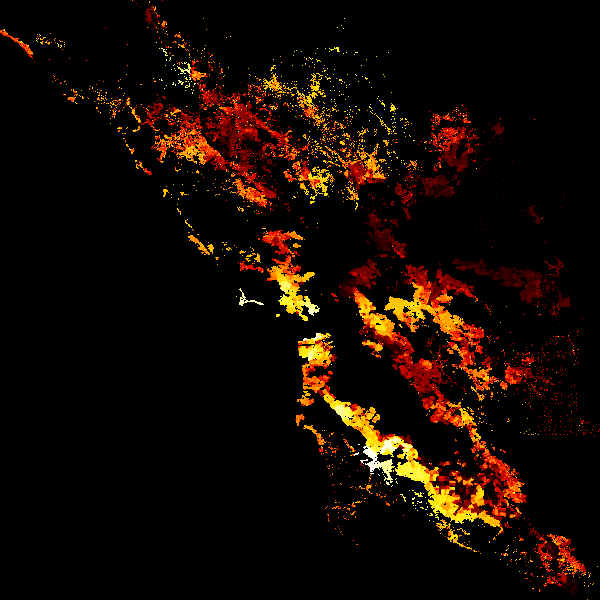

In [64]:
import datashader.transfer_functions as tf
from colorcet import fire
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(buildings[buildings.residential_units == 1], 'X', 'Y', ds.mean('res_price_per_sqft'))
img= tf.set_background(tf.shade(agg, cmap=fire),"black")
img

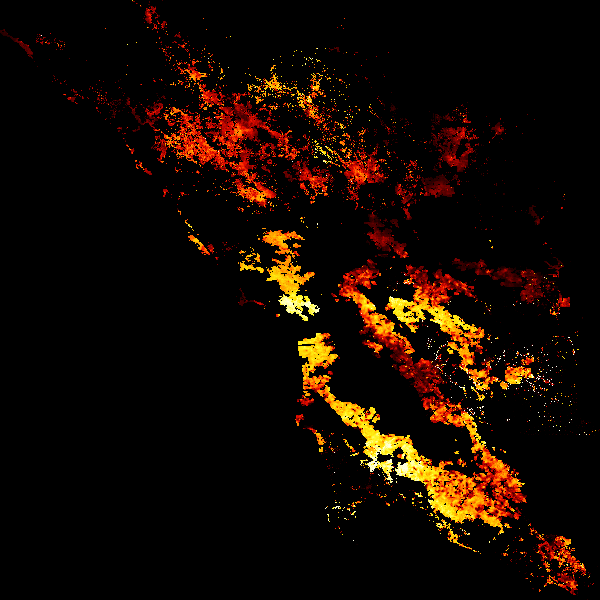

In [65]:
import datashader.transfer_functions as tf
from colorcet import fire
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(buildings[buildings.residential_units == 1], 'X', 'Y', ds.mean('predicted_price_sqft_sf'))
img= tf.set_background(tf.shade(agg, cmap=fire),"black")
img

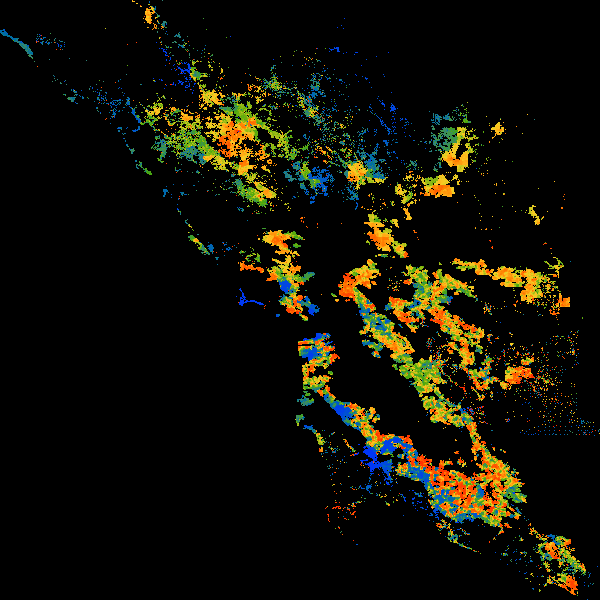

In [71]:
import datashader.transfer_functions as tf
from colorcet import rainbow
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(buildings[buildings.residential_units == 1], 'X', 'Y', ds.mean('residuals_price_sqft_sf'))
img= tf.set_background(tf.shade(agg, cmap=rainbow),"black")
img

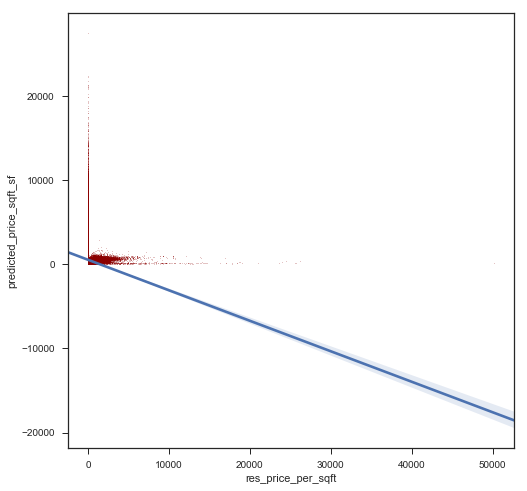

In [92]:
ax = sns.regplot(y = buildings[buildings.predicted_price_sqft_sf > 0].predicted_price_sqft_sf, \
                 x = buildings[buildings.predicted_price_sqft_sf > 0].res_price_per_sqft, \
                 scatter_kws={"color":"darkred","alpha":0.3,"s":1}\
               )

In [85]:
mm.initialize()

No files from ModelManager 0.1.dev8 or later found in path 'configs'


In [86]:
m.register()

Saving 'hedonic_price_sqft_single_family.yaml': /Users/Paul/src/urbansim_parcel_bayarea/configs
Loading model step 'hedonic_price_sqft_single_family'


In [87]:
orca.list_steps()

['test_manual_registration',
 'initialize_network_small',
 'initialize_network_drive',
 'initialize_network_walk',
 'network_aggregations_drive',
 'network_aggregations_small',
 'network_aggregations_walk',
 'hedonic_price_sqft_single_family']

In [73]:
m2 = OLSRegressionStep()
m2.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m2.filters = 'redfin_sale_year > 2010 & residential_units > 1 & sqft_per_unit > 50 & res_price_per_sqft < 2500'
m2.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + year_built > 2010 + \
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) + \
    np.log(avg_income_500_walk+1) + np.log(avg_income_10000+1) + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_25000 + 1) + np.log(pop_25000 + 1) +\
    np.log(pop_500_walk+1) + np.log(pop_black_500_walk+1) + np.log(pop_hisp_500_walk+1) + \
    np.log(pop_asian_500_walk+1)  '
m2.name = 'hedonic_price_sqft_multi_family'
m2.tags = ['paul', 'version 1']
m2.fit()

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.357
Model:                                      OLS   Adj. R-squared:                  0.356
Method:                           Least Squares   F-statistic:                     890.3
Date:                          Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                                  10:36:05   Log-Likelihood:                -28105.
No. Observations:                         28915   AIC:                         5.625e+04
Df Residuals:                             28896   BIC:                         5.641e+04
Df Model:                                    18                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [74]:
buildings = orca.get_table('buildings').to_frame()
buildings['predicted_ln_price_sqft_mf'] = 0.0
orca.add_table('buildings', buildings)
m2.out_column = 'predicted_ln_price_sqft_mf'
m2.run()

In [78]:
buildings['predicted_price_sqft_mf'] = np.exp(buildings['predicted_ln_price_sqft_mf']) - 1

In [79]:
buildings['residuals_price_sqft_mf'] = buildings.predicted_price_sqft_mf - buildings.res_price_per_sqft

In [80]:
buildings[['res_price_per_sqft','predicted_price_sqft_mf','residuals_price_sqft_mf']][buildings.residential_units > 1].describe()

,res_price_per_sqft,predicted_price_sqft_mf,residuals_price_sqft_mf
count,297274.000000,297274.000000,297274.000000
mean,372.355890,290.230217,-82.125673
std,440.821092,153.789094,383.807872
min,0.000000,-0.678729,-26109.774445
25%,168.864792,189.549286,-136.522723
50%,276.573207,252.103777,-28.242975
75%,443.358982,351.785677,61.367617
max,26233.219136,3349.949429,2484.356938


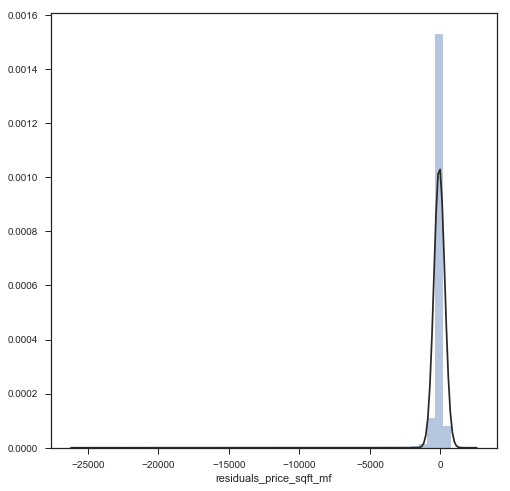

In [81]:
from scipy.stats import norm
plt.rcParams['figure.figsize']=8,8
#plot(residuals.mean(),0, residuals.mean(), 2.25)
sns.set_style("white")
sns.set_style("ticks")
ax = sns.distplot(buildings[buildings.residential_units > 1].residuals_price_sqft_mf, fit=norm, kde=False)

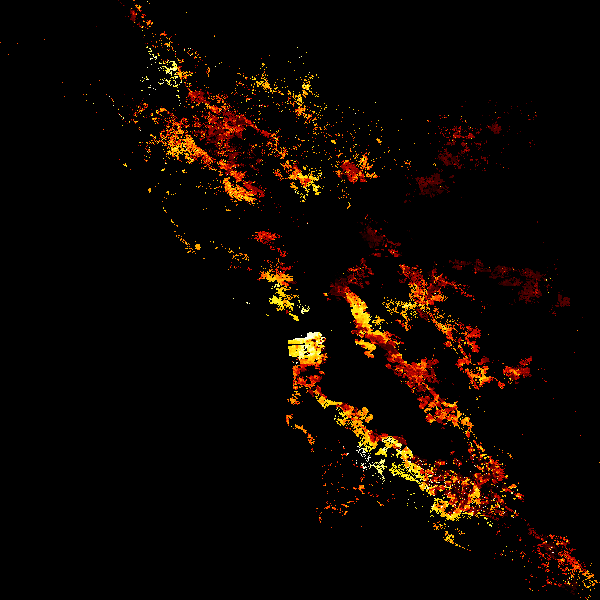

In [82]:
import datashader.transfer_functions as tf
from colorcet import fire
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(buildings[buildings.residential_units > 1], 'X', 'Y', ds.mean('res_price_per_sqft'))
img= tf.set_background(tf.shade(agg, cmap=fire),"black")
img

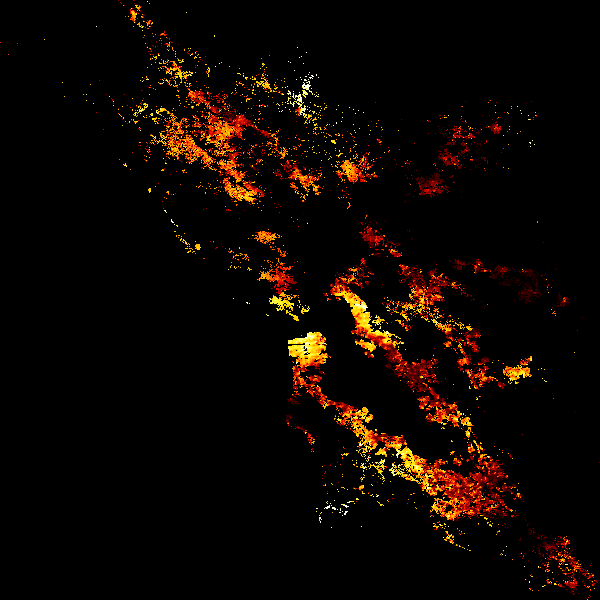

In [83]:
import datashader.transfer_functions as tf
from colorcet import fire
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(buildings[buildings.residential_units > 1], 'X', 'Y', ds.mean('predicted_price_sqft_mf'))
img= tf.set_background(tf.shade(agg, cmap=fire),"black")
img

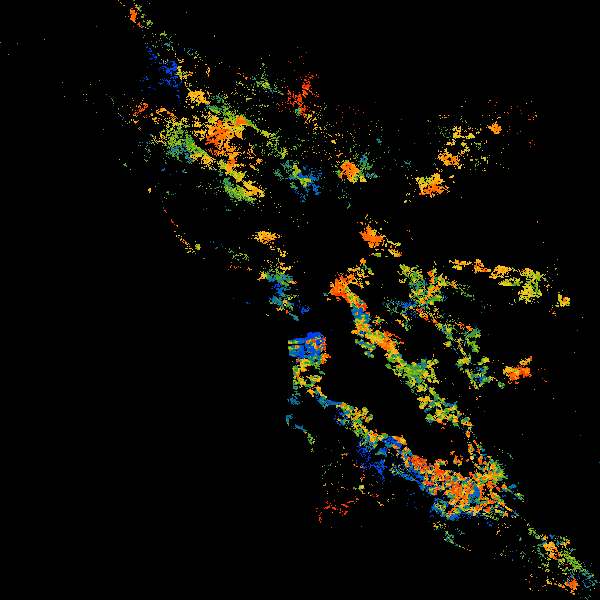

In [84]:
import datashader.transfer_functions as tf
from colorcet import rainbow
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.points(buildings[buildings.residential_units > 1], 'X', 'Y', ds.mean('residuals_price_sqft_mf'))
img= tf.set_background(tf.shade(agg, cmap=rainbow),"black")
img

In [88]:
m2.register()

Saving 'hedonic_price_sqft_multi_family.yaml': /Users/Paul/src/urbansim_parcel_bayarea/configs
Loading model step 'hedonic_price_sqft_multi_family'


In [89]:
orca.list_steps()

['test_manual_registration',
 'initialize_network_small',
 'initialize_network_drive',
 'initialize_network_walk',
 'network_aggregations_drive',
 'network_aggregations_small',
 'network_aggregations_walk',
 'hedonic_price_sqft_single_family',
 'hedonic_price_sqft_multi_family']

In [23]:
m3 = OLSRegressionStep()
m3.tables = ['buildings', 'parcels', 'nodeswalk', 'nodessmall']
m3.filters = 'redfin_sale_year > 2010 & sqft_per_unit > 50'
m3.model_expression = 'np.log1p(res_price_per_sqft) ~ + year_built + C(building_type_id) + \
    np.log(sqft_per_unit+1) + np.log(sqft_unit_500_walk+2)  + np.log(units_500_walk+1) + \
    np.log(rich_500_walk + 1) + np.log(singles_500_walk + 1) + np.log(elderly_hh_500_walk + 1) + \
    np.log(children_500_walk + 1) + \
    np.log(jobs_500_walk + 1) + np.log(jobs_1500_walk+1) + np.log(jobs_10000+1) + np.log(jobs_25000 + 1) + \
    np.log(pop_2500_walk+1) + np.log(pop_black_2500_walk+1) + np.log(pop_hisp_2500_walk+1) + \
    np.log(pop_asian_2500_walk+1) '
m3.name = 'hedonic_price_sqft_multi_family'
m3.tags = ['paul', 'version 1']
m3.fit()

                                 OLS Regression Results                                 
Dep. Variable:     np.log1p(res_price_per_sqft)   R-squared:                       0.424
Model:                                      OLS   Adj. R-squared:                  0.424
Method:                           Least Squares   F-statistic:                     5413.
Date:                          Mon, 16 Jul 2018   Prob (F-statistic):               0.00
Time:                                  22:42:19   Log-Likelihood:            -2.2577e+05
No. Observations:                        191518   AIC:                         4.516e+05
Df Residuals:                            191491   BIC:                         4.519e+05
Df Model:                                    26                                         
Covariance Type:                      nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
----------

In [ ]:
#    np.log(pop_10000+1) + np.log(pop_black_10000+1) + np.log(pop_hisp_10000+1) + \
#    np.log(pop_asian_10000+1) 

### If we like it, register it as an Orca step

In [ ]:
model.register()

In [ ]:
orca.list_steps()

### Run the Orca step

In [ ]:
orca.run(['RegressionStep-20180214-210159'])

### Check the fitted values

In [ ]:
df = orca.get_table('buildings').to_frame(['res_price_per_sqft', 'fitted_price'])
df.loc[df.fitted_price > 0].describe()

### BONUS

Running "model.register()" also registered the step with the new ModelManager extention, which saves it to disk so that it can be automatically re-loaded in the future.

The "test" model steps here were estimated earlier and loaded from disk. They're fully functional: we can run them in Orca, inspect the estimation results, etc.

In [ ]:
mm.list_steps()

In [ ]:
rs = mm.get_step('test-1')
type(rs)

In [ ]:
rs.model_expression

In [ ]:
rs.model.report_fit()